In [2]:
# Scientific libraries
              
import numpy as np              
import scipy as sp              
import pandas as pd              
import json              
import missingno as msno              

# Loading Plotting Modules
              
import matplotlib              
import matplotlib.pyplot as plt              
import seaborn as sns              
%matplotlib inline              
import chart_studio.plotly as py              
import plotly.figure_factory as ff              
import plotly.graph_objects as go              
import plotly.express as px              
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot              
init_notebook_mode(connected=True)              

# Setting Data Frame Options
              
pd.set_option('display.max_rows', 40)              
pd.set_option('display.max_columns', 50)              
pd.set_option('display.width', 100)              
pd.set_option('display.max_colwidth', 100)              

# Setting Plot Configuration
              
sns.set(rc={'figure.figsize':(19,11)}, style = 'white')              

# import katana.nbutil as ktn
              
import os

In [7]:
import os
import gc
import time
 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import auc, roc_curve

In [4]:
def auc_plot_score(model_pred_fn, X_train, X_test, y_train, y_test, dim=2): # Function to take a shortcut of printing plots and 
                                                                            # scores of auc for both train and test sets
    import matplotlib.pyplot as plt
    from sklearn.metrics import auc, roc_curve
    %matplotlib inline
    
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,5))
    fig.suptitle('AUC Plots', fontsize=20)
    
    if dim == 1:
        proba_train = model_pred_fn(X_train)
        proba_test  = model_pred_fn(X_test)
    elif dim == 2:
        proba_train = model_pred_fn(X_train)[:,1]
        proba_test  = model_pred_fn(X_test)[:,1]
        
    fpr_train, tpr_train, _ = roc_curve(y_train, proba_train, pos_label=1, drop_intermediate=False)
    auc_train = round(auc(fpr_train, tpr_train),5)
    
    fpr_test,  tpr_test , _ = roc_curve(y_test , proba_test,  pos_label=1, drop_intermediate=False)
    auc_test = round(auc(fpr_test, tpr_test), 5)
    
    axs[0].plot([0, 1], [0, 1], linestyle='--')
    axs[0].plot(fpr_train, tpr_train, marker='.')
    axs[0].set_title('Train')
    axs[0].set_xlabel(auc_train, fontsize=15)
    
    axs[1].plot([0, 1], [0, 1], linestyle='--')
    axs[1].plot(fpr_test, tpr_test, marker='.')
    axs[1].set_title('Test')
    axs[1].set_xlabel(auc_test, fontsize=15)
    
    plt.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()
    
    print(f'Train-set AUC Score = {auc_train}\nTest-set AUC Score = {auc_test}')

In [5]:
train = pd.read_parquet('./model_data/reduced_processed/train_set.pqt.gz')
y = train.isFraud
X = train.drop('isFraud', axis=1)

del train
gc.collect()

2448

In [8]:
import lightgbm as lgb

lgb_train = lgb.Dataset(data=X, label=y)

In [9]:
def lgbm_cv(boosting_types: list = ['gbdt']):
    
    res = {}
    start_time = time.time()
    
    for bt in boosting_types:
    
        cv_model_params = dict(
            task='train',
            boosting_type=bt,
            num_leaves=31,
            max_depth=-1,
            learning_rate=0.05,
            n_estimators=X.shape[1],
            subsample_for_bin=200000,
            objective='binary',
            class_weight=None,
            min_split_gain=0.0,
            min_child_weight=0.001,
            min_child_samples=20,
            subsample=1.0,
            subsample_freq=0,
            colsample_bytree=1.0,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=None,
            n_jobs=-1,
            silent=True,
            importance_type='split',
            verbose=-1
    )

        cv_params = dict(
            params=cv_model_params,
            train_set=lgb_train,
            num_boost_round=750,
            folds=None,
            nfold=5,
            stratified=True,
            shuffle=True,
            metrics='auc',
            fobj=None,
            feval=None,
            init_model=None,
            feature_name='auto',
            categorical_feature='auto',
            early_stopping_rounds=None,
            fpreproc=None,
            verbose_eval=None,
            show_stdv=True,
            seed=0,
            callbacks=None
    )

        res[bt] = lgb.cv(**cv_params)
        
        time_elapsed = time.time() - start_time
        print(f'Time Elapsed for "{bt}": {time_elapsed} seconds')
        start_time = time.time()
        
    return res

In [ ]:
%%time

boosting_types = [t.strip() for t in "gbdt, rf, dart, goss".split(',')]

eval_hist = lgbm_cv(boosting_types=boosting_types)

c:\python37\lib\site-packages\lightgbm\engine.py:430: UserWarning:

Found `n_estimators` in params. Will use it instead of argument

c:\python37\lib\site-packages\lightgbm\basic.py:741: UserWarning:

silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.



In [8]:
px.line(eval_hist, y='auc-mean', title=f"Model Performance (Mean AUC for 5-folds)")

In [10]:
px.line(eval_hist, y='auc-mean', title='Model Performance (Mean AUC for 5-folds)')

In [ ]:
def get_split(X, y, test_size=0.1, random_state=0):
    sss = StratifiedShuffleSplit(n_splits=1,
                                 test_size=test_size,
                                 random_state=0)
    
    for train_index, test_index in sss.split(X,y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    return X_train, X_test, y_train, y_test

In [40]:
X_train, X_dev, y_train, y_dev = get_split(X,y)

In [89]:
lgb_train = lgb.Dataset(data=X_train, label=y_train)

model_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.01,
    'verbose': -1
     }

training_params = dict(
            params=model_params,
            train_set=lgb_train,
            num_boost_round=1300,
            valid_sets=None,
            valid_names=None,
            fobj=None,
            feval=None,
            init_model=None,
            feature_name='auto',
            categorical_feature='auto',
            early_stopping_rounds=None,
            evals_result=None,
            verbose_eval=True,
            learning_rates=None,
            keep_training_booster=False,
            callbacks=None
)

lgb_model = lgb.train(**training_params)

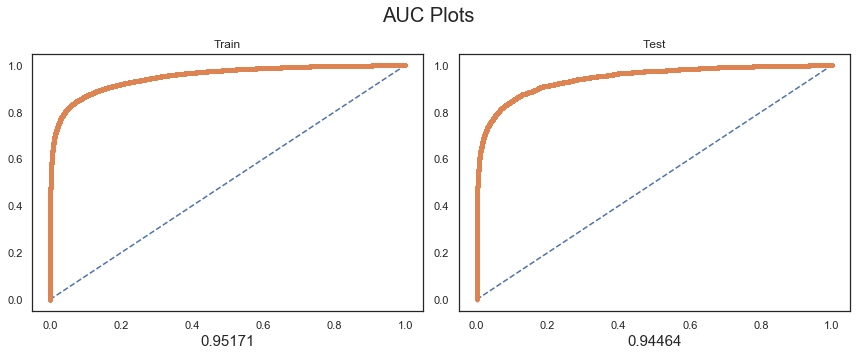

Train-set AUC Score = 0.95171
Test-set AUC Score = 0.94464


In [90]:
auc_plot_params = dict(
        model_pred_fn=lgb_model.predict,
        X_train=X_train,
        X_test=X_dev,
        y_train=y_train,
        y_test=y_dev,
        dim=1
)
auc_plot_score(**auc_plot_params)

In [91]:
gc.collect()

26075

Saving the model. LightGBM.Booster.save_model() 

To load the model from the saved model artifact, use: 

LightGBM.Booster(model_file='/path/to/model-artifact')

In [94]:
lgb_model.save_model('./model_artifacts/lgbm_rr_2.ml') 

In [11]:
test = pd.read_parquet('./model_data/reduced_processed/test_set.pqt.gz')
test.drop('isFraud', axis=1, inplace=True)

In [12]:
def submission_data(model, data, idx=None, fp = 'submission.csv'):
    y_score = model.predict(data)
    
    submission_data = pd.concat([pd.Series(idx), pd.Series(y_score)], axis=1)
    submission_data.columns = ['TransactionID', 'isFraud']
    submission_folder = os.path.join(wd,'submissions')
    os.makedirs(submission_folder, exist_ok=True)
    fp = os.path.join(submission_folder, fp)
    submission_data.to_csv(fp, index=False)

In [13]:
import subprocess

def shell(cmd):
    try:
        sub_cmd = subprocess.Popen(cmd,
                                   shell=True,
                                   stdout=subprocess.PIPE)
    except Exception as e:
        logger.error('Exception occurred during shell execution. Message: %s' % e)
    else:
        output = sub_cmd.communicate()[0].decode('utf-8')
        print(output)
        return output

In [14]:
def submit_result(submission_file = 'submission.csv', message='Submission made.'):
    s_file = os.path.join(wd, 'submissions', submission_file)
    submit_cmd = f'kaggle competitions submit -f {s_file} -m {message} -c ieee-fraud-detection'
    shell(submit_cmd)

In [112]:
submit_result('submission.csv')

Could not find competition - please verify that you entered the correct competition ID and that the competition is still accepting submissions.

